In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import queue
from scipy.integrate import solve_ivp
from scipy.signal import spectrogram
from tqdm import tqdm

In [2]:
np.random.seed(100)

In [3]:
# Parameters
gamma = 12000 

duration = 0.050 #s
dt = 1/44100 #s  #* 0.1 #1.e-4

Amp = 4

nt = int(duration/dt)

# Trachea parameters
r=-0.9
v=350*100
L=1.9
tau_0=2*L/v # Propagation time along trachea
tau_n=int(tau_0/dt)

In [4]:
def syrinxODE(t, y):
    ''' ODEs used in Amador paper'''
    
    global P_alpha, T_beta
    
    y0, y1 = y
    dydt = [y1,
         -Pressure(t, P_alpha)*(gamma**2) - Tension(t, T_beta)*(gamma**2)*y0 - (gamma**2)*(y0**3) - gamma*(y0**2)*y1 + (gamma**2)*(y0**2) - gamma*y0*y1
           ]

    return dydt

In [5]:
def Syrinx(P_alpha, T_beta):
    ''' Simulating a syrinx using pressure and tension inputs. '''
    solution = solve_ivp(syrinxODE, [0, duration], [1, 1], method = "RK45", t_eval = np.linspace(0,duration,nt), rtol = 1e-8, atol = 1e-8)
    
    # Extract labial position (X) and velocity (Y)
    X = solution['y'][0]
    Y = solution['y'][1]
    
    time_x = np.linspace(0, duration, nt)
    song = Amp * Pressure(time_x, P_alpha) * Y
    
    return song

In [6]:
def Trachea(song):
    """ Simulating the progression of pressure through a trachea. """
    
    y0 = song.T

    # To generate pressure output from trachea
    P_i=np.zeros((len(y0)))

    # See Fig 1 in Amador paper. Round-about way to implement that.
    Buffer = queue.Queue()
    for i in np.arange(tau_n):
        Buffer.put(np.random.random())

    for i in np.arange(len(y0)):
        P_i[i] = y0[i] - r*Buffer.get();      
        # update_buffer
        Buffer.put(P_i[i])

    # P_tr from P_in (ref Amador paper)
    BufferB=np.zeros((tau_n))
    P_tmp= np.concatenate((BufferB, P_i))
    P_t=(1-r)*P_tmp[:-tau_n]
    return P_t


In [7]:
# # RC5 - test
# def Tension(t, T_beta):
#     """ Generalised exponential waveform """
    
#     return   .3 - .2*np.exp(-T_beta*3*100*t) -.00001 * np.exp(T_beta*3*100*t) 

    
# def Pressure(t, P_alpha):
#     """ Constant """
#     return P_alpha*np.sin((duration/2 + t)*np.pi*10) + 0.05

In [8]:
#RC 4
def Tension(t, T_beta):
    """ Generalised exponential waveform """
    return   -.2*np.exp(-200*t) -.00001 * np.exp(200*t)  + T_beta

    
def Pressure(t, P_alpha):
    """ Constant """
    return 0.04*np.sin((duration/2 + t)*np.pi*10) + P_alpha

In [9]:
# # RC4rejected because only 1 minimum
# def Tension(t, T_beta):
#     """ Generalised exponential waveform """
#     return   (1.2 * np.exp(-80*t) - np.exp(-300*t)) + T_beta
    
# def Pressure(t, P_alpha):
#     """ Constant """
# #     return np.ones((np.asarray(t).shape)) * 0.02
#     return 0.04*np.sin((duration/2 + t)*np.pi*10) * P_alpha

In [10]:
# #RC3
# def Tension(t, T_beta):
#     """ Generalised exponential waveform """
#     return   (1.2 * np.exp(-80*t) - np.exp(-300*t)) + T_beta
    
# def Pressure(t, P_alpha):
#     """ Constant """
#     return np.ones((np.asarray(t).shape)) * P_alpha

In [11]:
#RC2
# def Tension(t, T_beta):
#     """ Generalised exponential waveform """
#     return   (1.2 * np.exp(-80*t) - np.exp(-300*t)) + T_beta
    
# def Pressure(t, P_alpha):
#     """ Constant """
#     return np.ones((np.asarray(t).shape)) * P_alpha

In [12]:
#RC1
# Initial reward contour
# def Tension(t, T_beta):
#     """ Tension = T_beta * np.ones((nt)) """
    
#     return np.ones((np.asarray(t).shape)) * T_beta
    
# def Pressure(t, P_alpha):
#     """ Pressure = P_alpha * np.ones((nt)) """
    
#     return np.ones((np.asarray(t).shape)) * P_alpha

In [13]:
def plot_gradient(ax, Z, figure):
    """ Plots reward contour. """

    contour = ax.contourf(Z, 25, extent=[0.0, 1.0, 0.0, 0.2], cmap="gray_r", alpha=.25)
#     cbar = figure.colorbar(contour)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.5)
    cbar = figure.colorbar(contour, cax=cax)
    cbar.set_label('Performance metric (R)', rotation=270, fontsize=20, labelpad=25)
    

In [14]:
def create_template(P_alpha=0.02, T_beta=0.6):
    """ Creates spectrogram template from target song. """

    song = Syrinx(P_alpha, T_beta)
    P_tr = Trachea(song)
    (freqs, t, spectrum) = spectrogram(P_tr, fs=1/dt)
    target_spectrum = spectrum

    templateSpec = target_spectrum
    mts = np.mean(templateSpec)
    templateSpec = templateSpec - mts
    templateLen = np.sqrt(np.sum(templateSpec ** 2))
    templateSpec = templateSpec / templateLen
    
    return templateSpec

In [15]:

def compute_corr_coeff(currentSpec, templateSpec):
    """ Computes correlation coefficient. """

    m = np.mean(currentSpec)
    currentSpec = currentSpec - m
    currentLen = np.sqrt(np.sum(currentSpec ** 2))
    currentSpec = currentSpec / currentLen
    
    return np.mean(currentSpec.T@templateSpec)

In [16]:
def generate_gradient(templateSpec, n=256):
    """ Generates the reward contour by simulating the song for each input combination
        and storing the similarity metric w.r.t. the target song. """
    
    global P_alpha, T_beta
    
    Spectrums = np.zeros((n, n, 129, 9)) # Hardcoded in a hurry
#     Spectrums = np.load('Figures/spectrums_n'+str(n)+'.npy')
    
    Z = np.zeros((n,n))
    for i in tqdm(np.arange(n)):
        for j in np.arange(n):
            P_alpha = i/n*0.2 #+ 0.0
            T_beta = j/n*1. #+ 0.0
            song = Syrinx(P_alpha, T_beta)
            P_tr = Trachea(song)
            (freqs, t, spectrum) = spectrogram(P_tr, fs=1/dt)
            Spectrums[i, j] = spectrum
#             spectrum = Spectrums[i, j]
            Z[i, j] = compute_corr_coeff(spectrum, templateSpec)

#     np.save('Figures/spectrums_n'+str(n), Spectrums)
    return Z
            
    

In [17]:
# Assign target song

P_alpha = 0.05
T_beta = .3

templateSpec = create_template(P_alpha, T_beta)

In [23]:
# Generate reward contour
nZ = 20
Z = generate_gradient(templateSpec, nZ)
Z = Z/np.max(Z)


100%|██████████| 20/20 [06:25<00:00, 19.30s/it]


In [27]:
Z = Z/np.max(Z)

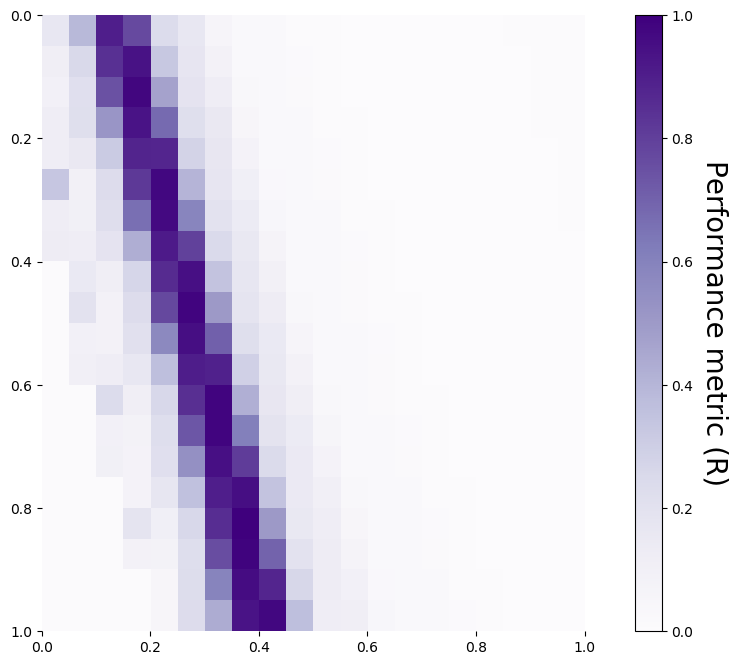

In [28]:
figure = plt.figure(figsize=(8,8))
ax = plt.subplot(frameon=False)

# im = ax.imshow(Z , vmin=0, vmax=Z.max(), cmap='Purples', extent=[0, 0.1, 0, 0.02], aspect='auto')
im = ax.imshow(Z , vmin=0, vmax=Z.max(), cmap='Purples', extent=[0, 1, 0, 1], aspect='auto')
ax.invert_yaxis() 

# Display colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.5)
cbar = figure.colorbar(im, cax=cax)
cbar.set_label('Performance metric (R)', rotation=270, fontsize=20, labelpad=25)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

# ax.get_xaxis().set_ticks([])
# ax.get_yaxis().set_ticks([])

In [30]:
np.save('Figures/Z-T03_P005_n'+str(nZ), Z)

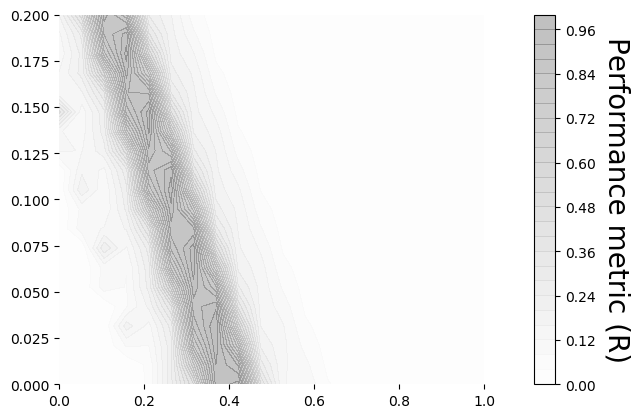

In [31]:
# Z = np.load('SyrinxOutput/rc4/Z-T03_P005_n10.npy')

figure = plt.figure()
ax = plt.subplot(frameon=False)

# Plot reward contour
plot_gradient(ax, Z, figure)